In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [88]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [89]:
df = pd.read_csv('bank.csv')

In [90]:
df.shape

(11162, 17)

In [91]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [92]:
df['deposit'].unique()

array(['yes', 'no'], dtype=object)

## Continuous Feature

In [93]:
cont_feat = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [94]:
def describe_cont_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby('deposit')[feature].describe())

In [95]:
for feat in cont_feat:
    describe_cont_feature(feat)


*** Results for age ***
          count       mean        std   min   25%   50%   75%   max
deposit                                                            
no       5873.0  40.837391  10.264815  18.0  33.0  39.0  48.0  89.0
yes      5289.0  41.670070  13.497781  18.0  31.0  38.0  50.0  95.0

*** Results for balance ***
          count         mean          std     min    25%    50%     75%  \
deposit                                                                   
no       5873.0  1280.227141  2933.411934 -6847.0   64.0  414.0  1324.0   
yes      5289.0  1804.267915  3501.104777 -3058.0  210.0  733.0  2159.0   

             max  
deposit           
no       66653.0  
yes      81204.0  

*** Results for day ***
          count       mean       std  min  25%   50%   75%   max
deposit                                                         
no       5873.0  16.108122  8.322071  1.0  9.0  16.0  22.0  31.0
yes      5289.0  15.158253  8.501875  1.0  8.0  15.0  22.0  31.0

*** Results

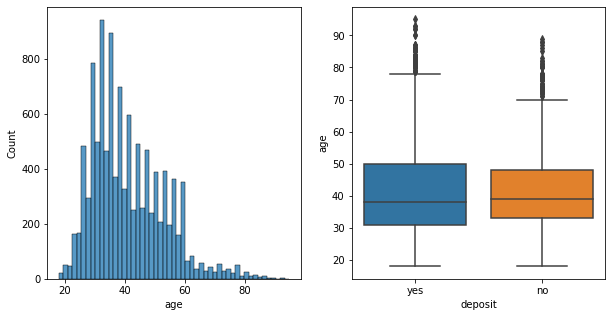

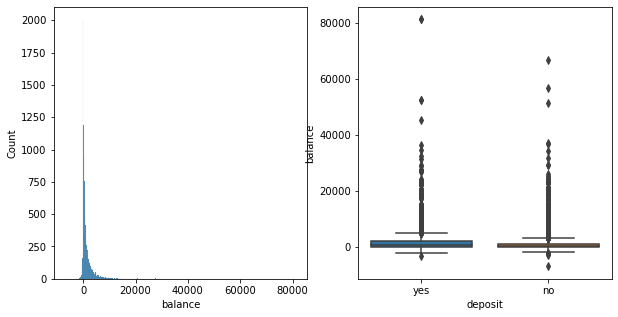

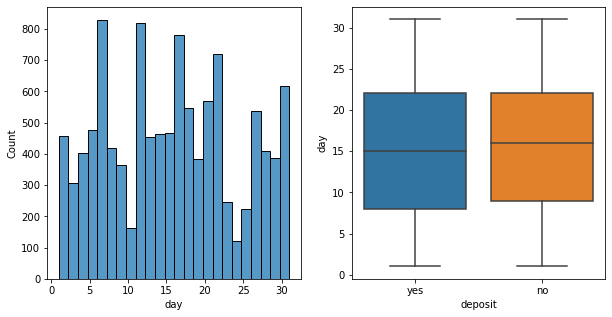

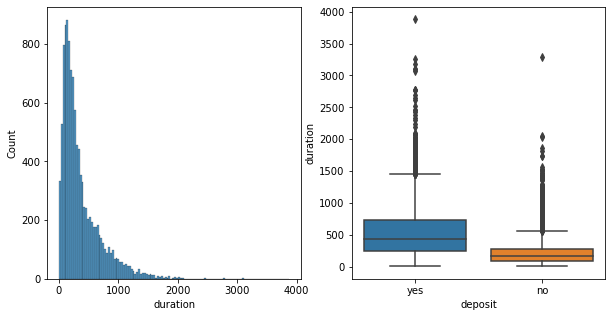

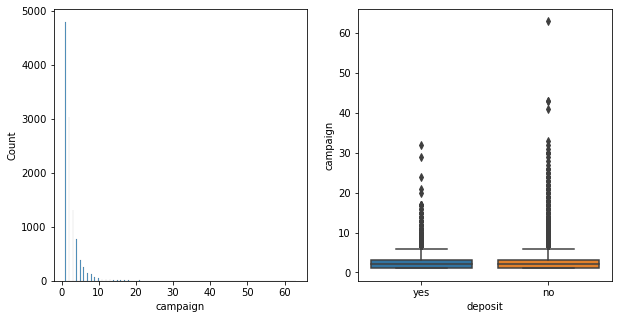

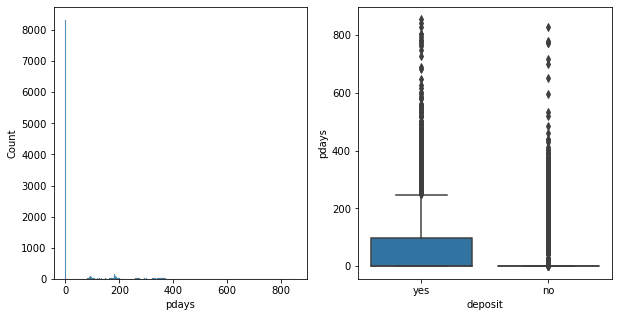

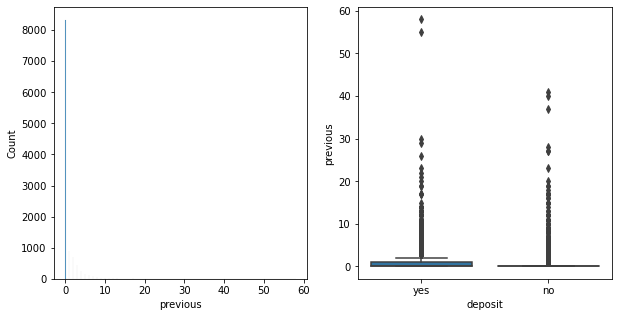

In [96]:
for col in cont_feat:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(data = df, x = col, ax=ax[0])
    sns.boxplot(x='deposit',y=col, data=df, ax=ax[1])
    plt.show()

In [97]:
df['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [98]:
def detect_outliers(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean) / std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\n Outliers caps for {}: '.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                          len([i for i in data if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3 * std, len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99), 
                                                          len([i for i in data if i > data.quantile(.99)])))

In [99]:
# for feat in cont_feat:
#     detect_outliers(feat)

### Remove Outiers

In [100]:
for feat in cont_feat:
    df[feat].clip(upper = df[feat].quantile(.99), inplace = True)

## Categorical Variables

In [101]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042.0,1,-1.0,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467.0,1,-1.0,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389.0,1,-1.0,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579.0,1,-1.0,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673.0,2,-1.0,0,unknown,yes


In [102]:
df['deposit'] = df['deposit'].replace({'yes':1,'no':0})

In [103]:
cat_feat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

<Figure size 720x360 with 0 Axes>

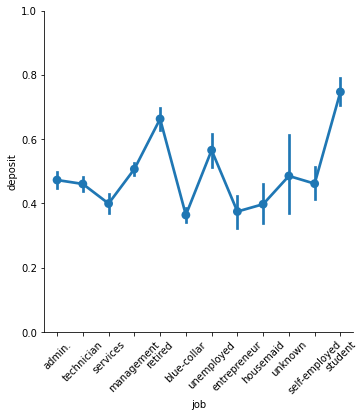

<Figure size 720x360 with 0 Axes>

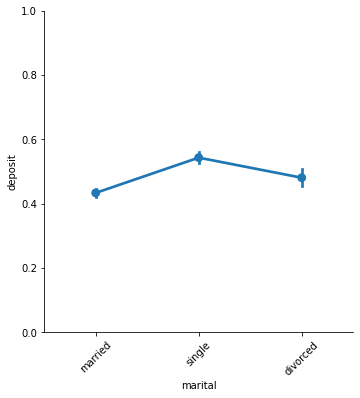

<Figure size 720x360 with 0 Axes>

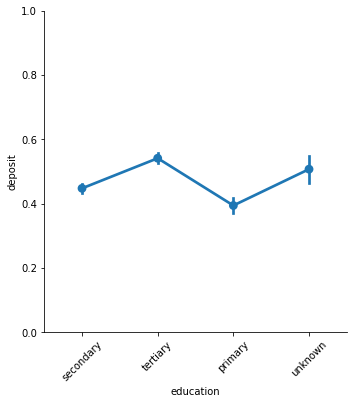

<Figure size 720x360 with 0 Axes>

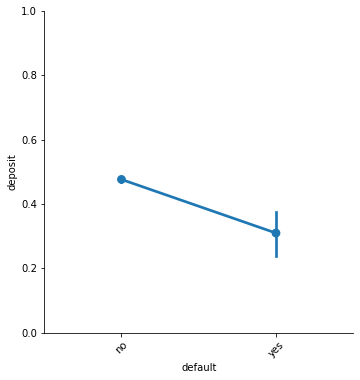

<Figure size 720x360 with 0 Axes>

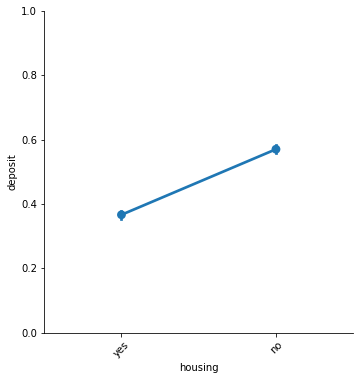

<Figure size 720x360 with 0 Axes>

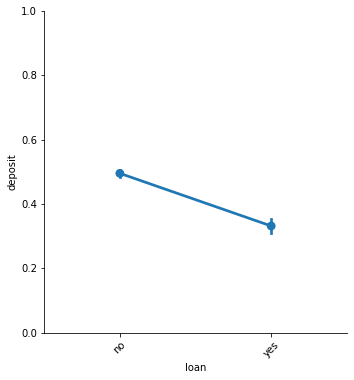

<Figure size 720x360 with 0 Axes>

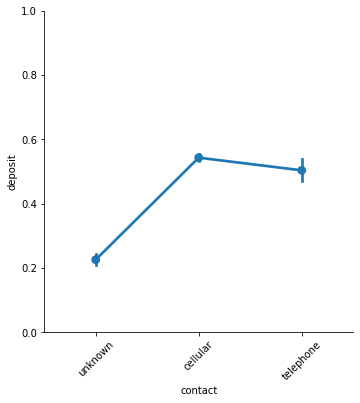

<Figure size 720x360 with 0 Axes>

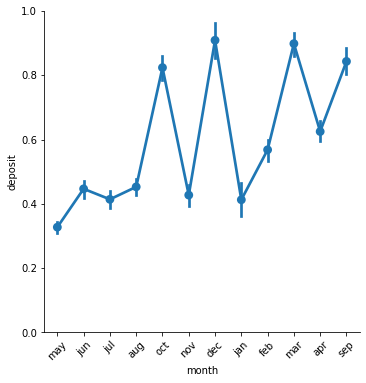

<Figure size 720x360 with 0 Axes>

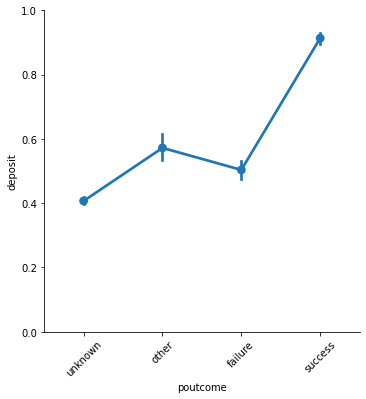

In [104]:
for col in cat_feat:
    plt.figure(figsize = (10,5))
    sns.catplot(x = col, y = 'deposit', data = df, kind = 'point', ascept = 2)
    plt.ylim(0, 1)
    plt.xticks(rotation = 45)
    plt.show()

C:\Users\mayursaid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


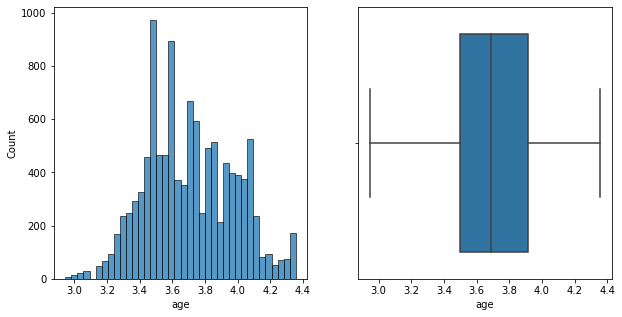

C:\Users\mayursaid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


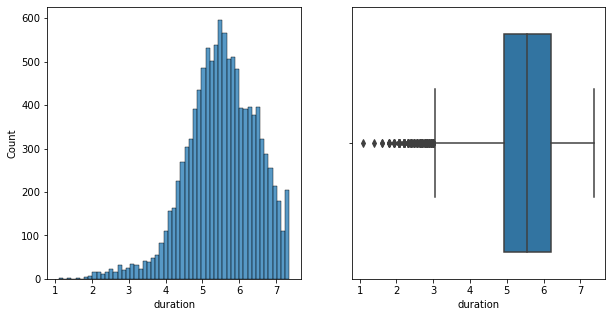

In [107]:
for col in ['age', 'duration']:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(np.log(df[col] + 1), ax=ax[0])
    sns.boxplot(np.log(df[col] + 1), ax=ax[1])
    plt.show()

## Transformation

In [20]:
df['log_age'] = np.log(df['age'])
df['log_duration'] = np.log(df['duration'])

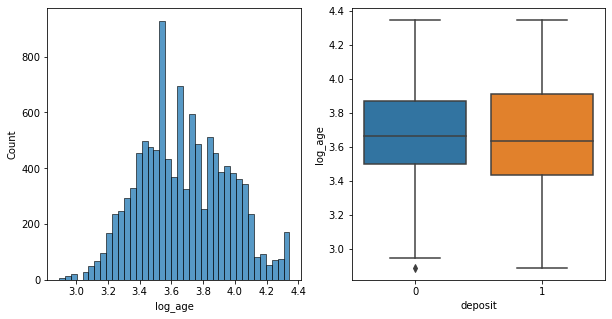

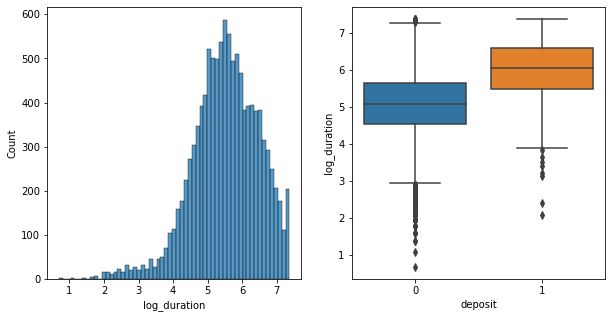

In [21]:
for col in ['log_age', 'log_duration']:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(data = df, x = col, ax=ax[0])
    sns.boxplot(x='deposit',y=col, data=df, ax=ax[1])
    plt.show()

In [22]:
df_final = df.drop(['age', 'duration'], axis=1)

In [23]:
cat_feat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [24]:
# for col in cat_feat:
#     dummy_cols = pd.get_dummies(df_final[col], drop_first=True, prefix=col)
#     df_final = pd.concat([df_final,dummy_cols],axis=1)
#     df_final.drop(columns=col, inplace=True)

In [25]:
df_final.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,log_age,log_duration
0,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1,-1.0,0,unknown,1,4.077537,6.948897
1,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1,-1.0,0,unknown,1,4.025352,7.290975
2,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1,-1.0,0,unknown,1,3.713572,7.236339
3,services,married,secondary,no,2476.0,yes,no,unknown,5,may,1,-1.0,0,unknown,1,4.007333,6.361302
4,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,2,-1.0,0,unknown,1,3.988984,6.511745


## Train Val Test Split

In [26]:
y = df_final['deposit'].copy()
X = df_final.drop(['deposit'], axis=1)

In [27]:
#split dataset in training, validation and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =42)

In [28]:
X_train.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,log_age,log_duration
10327,management,married,tertiary,no,5381.0,no,no,cellular,17,nov,1,-1.0,0,unknown,3.401197,5.926926
6902,self-employed,married,secondary,no,131.0,yes,no,unknown,8,may,1,-1.0,0,unknown,3.401197,5.723585
5648,management,divorced,tertiary,no,-207.0,no,no,cellular,2,feb,1,-1.0,0,unknown,4.007333,5.351858
9462,management,divorced,tertiary,no,12.0,no,no,cellular,17,jul,1,-1.0,0,unknown,3.465736,5.771441
6232,self-employed,married,secondary,no,-199.0,yes,yes,cellular,29,jan,1,-1.0,0,unknown,3.891820,5.953243


In [29]:
X_train.shape, y_train.shape

((6697, 16), (6697,))

In [30]:
y_train.value_counts()

0    3571
1    3126
Name: deposit, dtype: int64

In [31]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(y), 2))

0.6
0.2
0.2


### Mean Encoding

In [32]:
cat_feat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [33]:
y = 'deposit'
X_train = X_train.join(y_train)
for col in cat_feat:
    target_mean = X_train.groupby(col)[y].mean()
    X_val[col + '_enc'] = X_val[col].map(target_mean)
    X_test[col + '_enc'] = X_test[col].map(target_mean)
    
    #global target mean
    global_mean = X_train[y].mean()
    
    #mean encode title_raw with KFlod regularization
    skf = KFold(n_splits = 7, shuffle = True, random_state = 100)
    for train_ind, val_ind in skf.split(X_train):
        X_tr, X_v = X_train.iloc[train_ind].copy(), X_train.iloc[val_ind].copy()
        means = X_v[col].map(X_tr.groupby(col)[y].mean())
        X_train.loc[X_train.index[val_ind], col+'_enc'] = means
    #Fill title_raw_enc with target global mean
    X_train[col+'_enc'].fillna(global_mean, inplace = True)
    X_val[col+'_enc'].fillna(global_mean, inplace = True)
    X_test[col+'_enc'].fillna(global_mean, inplace = True)

In [34]:
#Drop col from X_train, X_val and X_test
for col in cat_feat:
    X_train.drop([col], axis = 1, inplace = True)
    X_val.drop([col], axis = 1, inplace = True)
    X_test.drop([col], axis = 1, inplace = True)

In [35]:
#Drop Survived from X_train
X_train.drop([y], axis = 1, inplace = True)

In [36]:
X_train.head()

,balance,day,campaign,pdays,previous,log_age,log_duration,job_enc,marital_enc,education_enc,default_enc,housing_enc,loan_enc,contact_enc,month_enc,poutcome_enc
10327,5381.0,17,1,-1.0,0,3.401197,5.926926,0.507901,0.435171,0.541602,0.469892,0.562643,0.489751,0.538369,0.418468,0.396947
6902,131.0,8,1,-1.0,0,3.401197,5.723585,0.478873,0.437139,0.438634,0.472045,0.361527,0.491298,0.223618,0.328710,0.401796
5648,-207.0,2,1,-1.0,0,4.007333,5.351858,0.498150,0.452888,0.532176,0.463497,0.558698,0.482717,0.528702,0.563725,0.392461
9462,12.0,17,1,-1.0,0,3.465736,5.771441,0.498150,0.452888,0.532176,0.463497,0.558698,0.482717,0.528702,0.402985,0.392461
6232,-199.0,29,1,-1.0,0,3.891820,5.953243,0.461207,0.427877,0.438834,0.467055,0.361742,0.328982,0.535783,0.382166,0.394191


### Scaling

In [37]:
scaler = MinMaxScaler()

In [38]:
X_train = scaler.fit_transform(X_train)

In [39]:
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [40]:
X_train[:2]

array([[0.51820758, 0.53333333, 0.        , 0.        , 0.        ,
        0.35146126, 0.78464623, 0.43351481, 0.0913871 , 0.98282978,
        0.97949757, 0.99568738, 0.98319053, 1.        , 0.17425299,
        0.00854473],
       [0.19582462, 0.23333333, 0.        , 0.        , 0.        ,
        0.35146126, 0.75416144, 0.36224879, 0.10825509, 0.4040387 ,
        0.99173899, 0.04902764, 0.99216716, 0.02665097, 0.02033406,
        0.01778196]])

## Smote

In [41]:
sm = SMOTE(random_state = 100)

In [42]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [43]:
df.shape

(11162, 19)

In [44]:
pd.DataFrame(X_train).shape

(7142, 16)

## Training

In [45]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    auc_roc = round(roc_auc_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- \tAUC_ROC: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                     auc_roc,
                                                                                     precision,
                                                                                     recall,
                                                                                     round((end - start)*1000, 1)))
    return auc_roc, precision, recall
    

### Logistic Regression

In [46]:
scores = []

In [47]:
params = {
    'C': [100, 10, 1.0, 0.1, 0.01]
}

In [48]:
LR = LogisticRegression(max_iter=10000)
grid_LR = GridSearchCV(estimator=LR, param_grid=params, n_jobs=-1, cv=10, scoring='f1')
grid_LR.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]}, scoring='f1')

In [49]:
train_auc_roc, train_precision, train_recall = evaluate_model('LR', grid_LR, X_train, y_train)

LR -- 	AUC_ROC: 0.822 / Precision: 0.812 / Recall: 0.839 / Latency: 1.0ms


In [50]:
val_auc_roc, val_precision, val_recall = evaluate_model('LR', grid_LR, X_val, y_val)

LR -- 	AUC_ROC: 0.821 / Precision: 0.794 / Recall: 0.846 / Latency: 1.0ms


In [51]:
test_auc_roc, test_precision, test_recall = evaluate_model('LR', grid_LR, X_test, y_test)

LR -- 	AUC_ROC: 0.821 / Precision: 0.813 / Recall: 0.824 / Latency: 1.0ms


In [52]:
model_name = 'Logistic Regression'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### SVM

In [53]:
from sklearn import svm

In [54]:
#Create a svm Classifier
svm = svm.SVC(gamma = 'auto', probability=True)

#Train the model using the training sets
svm.fit(X_train, y_train)

SVC(gamma='auto', probability=True)

In [55]:
evaluate_model('SVM', svm, X_test, y_test)

SVM -- 	AUC_ROC: 0.832 / Precision: 0.803 / Recall: 0.867 / Latency: 864.0ms


(0.832, 0.803, 0.867)

In [56]:
train_auc_roc, train_precision, train_recall = evaluate_model('svm', svm, X_train, y_train)

svm -- 	AUC_ROC: 0.832 / Precision: 0.804 / Recall: 0.878 / Latency: 2783.5ms


In [57]:
val_auc_roc, val_precision, val_recall = evaluate_model('svm', svm, X_val, y_val)

svm -- 	AUC_ROC: 0.827 / Precision: 0.786 / Recall: 0.875 / Latency: 857.7ms


In [58]:
test_auc_roc, test_precision, test_recall = evaluate_model('svm', svm, X_test, y_test)

svm -- 	AUC_ROC: 0.832 / Precision: 0.803 / Recall: 0.867 / Latency: 862.0ms


In [59]:
model_name = 'SVM'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [62]:
# DT = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# DT = clf.fit(X_train,y_train)

In [63]:
DT = DecisionTreeClassifier()
grid_DT = GridSearchCV(estimator=DT, param_grid=params, n_jobs=-1, cv=10, scoring='roc_auc')
grid_DT.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='roc_auc')

In [64]:
train_auc_roc, train_precision, train_recall = evaluate_model('DT', grid_DT, X_train, y_train)

DT -- 	AUC_ROC: 0.852 / Precision: 0.832 / Recall: 0.882 / Latency: 1.0ms


In [65]:
val_auc_roc, val_precision, val_recall = evaluate_model('DT', grid_DT, X_val, y_val)

DT -- 	AUC_ROC: 0.836 / Precision: 0.805 / Recall: 0.865 / Latency: 1.0ms


In [66]:
test_auc_roc, test_precision, test_recall = evaluate_model('DT', grid_DT, X_test, y_test)

DT -- 	AUC_ROC: 0.835 / Precision: 0.809 / Recall: 0.866 / Latency: 1.0ms


In [67]:
model_name = 'DT'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### Random Forest

In [68]:
# xgb_model = XGBClassifier(random_state=100, use_label_encoder=False, n_jobs=-1)

# xgb_model.fit(X_train, y_train)

In [69]:
params = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, 64, None],
}

In [70]:
RF = RandomForestClassifier()
grid_RF = GridSearchCV(RF, params, cv = 10, scoring = 'roc_auc', n_jobs = -1)
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256, 512]},
             scoring='roc_auc')

In [71]:
train_auc_roc, train_precision, train_recall = evaluate_model('RF', grid_RF, X_train, y_train)

RF -- 	AUC_ROC: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 243.0ms


In [72]:
val_auc_roc, val_precision, val_recall = evaluate_model('RF', grid_RF, X_val, y_val)

RF -- 	AUC_ROC: 0.861 / Precision: 0.811 / Recall: 0.922 / Latency: 94.0ms


In [73]:
test_auc_roc, test_precision, test_recall = evaluate_model('RF', grid_RF, X_test, y_test)

RF -- 	AUC_ROC: 0.858 / Precision: 0.822 / Recall: 0.902 / Latency: 94.0ms


In [74]:
model_name = 'RF'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

## XgBoost

In [75]:
params = {
    'n_estimators': [2**i for i in range(3, 10)],
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'max_depth': np.arange(1, 10, 1),
    'subsample': np.arange(0, 1.1, 0.1),
    'min_child_weight': [1, 2, 3, 4, 5, 10, 50, 100],
    'reg_alpha': [1, 2, 3, 4, 5, 10, 50, 100],
    'reg_lambda':  [1, 2, 3, 4, 5, 10, 50, 100],
    'colsample_bytree':  np.arange(0, 1.1, 0.1),
    'colsample_bylevel':  np.arange(0, 1.1, 0.1),
}

In [76]:
xgb = XGBClassifier(objective = 'binary:logistic')

In [77]:
random_xgb = RandomizedSearchCV(xgb, params, cv = 5, scoring = 'roc_auc',
                                 n_iter = 500, random_state = 10, return_train_score = False, n_jobs = -1)
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                  

In [78]:
train_auc_roc, train_precision, train_recall = evaluate_model('XGB', random_xgb, X_train, y_train)

XGB -- 	AUC_ROC: 0.917 / Precision: 0.891 / Recall: 0.95 / Latency: 14.0ms


In [79]:
val_auc_roc, val_precision, val_recall = evaluate_model('XGB', random_xgb, X_val, y_val)

XGB -- 	AUC_ROC: 0.858 / Precision: 0.81 / Recall: 0.913 / Latency: 5.0ms


In [80]:
test_auc_roc, test_precision, test_recall = evaluate_model('XGB', random_xgb, X_test, y_test)

XGB -- 	AUC_ROC: 0.856 / Precision: 0.819 / Recall: 0.902 / Latency: 11.0ms


In [81]:
pd.DataFrame(scores)

model_name = 'XGB'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

In [82]:
pd.DataFrame(scores)

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall
0,Logistic Regression,0.822,0.821,0.821,0.813,0.824
1,SVM,0.832,0.827,0.832,0.803,0.867
2,DT,0.852,0.836,0.835,0.809,0.866
3,RF,1.000,0.861,0.858,0.822,0.902
4,XGB,0.917,0.858,0.856,0.819,0.902


In [83]:
pd.DataFrame(scores)

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall
0,Logistic Regression,0.822,0.821,0.821,0.813,0.824
1,SVM,0.832,0.827,0.832,0.803,0.867
2,DT,0.852,0.836,0.835,0.809,0.866
3,RF,1.000,0.861,0.858,0.822,0.902
4,XGB,0.917,0.858,0.856,0.819,0.902


In [84]:
def cal_f1_score(precision, recall):
    return round(2 * (precision * recall)/(precision + recall), 3)

results = pd.DataFrame(scores)
results['Test F1 Score'] = cal_f1_score(results['Test Precision'], results['Test Recall'])

In [85]:
#Mean Encoding

In [86]:
results

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.822,0.821,0.821,0.813,0.824,0.818
1,SVM,0.832,0.827,0.832,0.803,0.867,0.834
2,DT,0.852,0.836,0.835,0.809,0.866,0.837
3,RF,1.000,0.861,0.858,0.822,0.902,0.860
4,XGB,0.917,0.858,0.856,0.819,0.902,0.858
